## Informations sur le dataset
- Le lien : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

##### Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." 

##### Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


Tenure : Number of months the customer has stayed with the company


### Import des packages

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline
pd.set_option('display.max_columns', None)

### Premières informations
- 7043 lignes et 21 colonnes (18 de types object, 2 de type int, et 1 de type float).
    - TotalCharges de type object alors que normalement de type float (11 lignes où la valeur n'est pas rensiegnée)
    - Bcp de colonnes de classification binaire de type object --> type int 0 ou 1
- Pas de doublons sur la colonne customerID donc sur le df
- 11 valeurs manquantes dans la colonne TotalCharges sinon rien donc dans un premier temps on va supprimer ces 11 lignes
- Variable Churner : 25% de churner, jeux de données déséquilibrés
- Pas de valeurs aberrantes sur les données numériques


In [121]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', na_values = [' ', None])
df.head(2)
df.drop('customerID', axis = 1, inplace = True)
df = df.dropna(how = 'any')

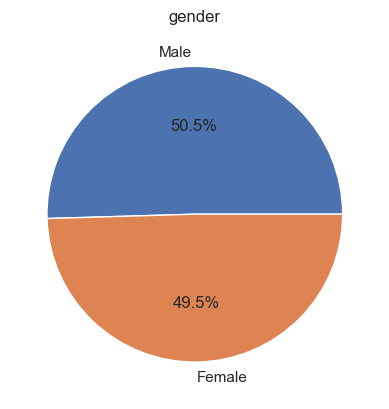

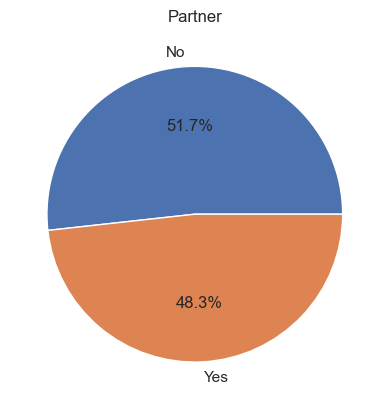

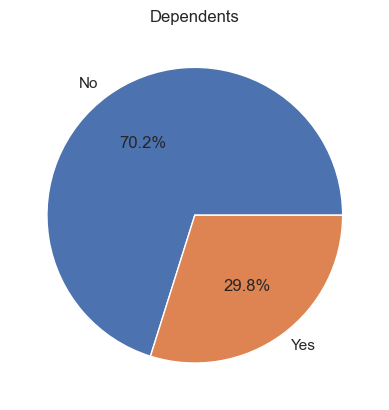

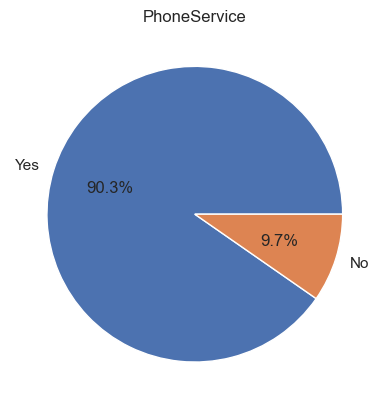

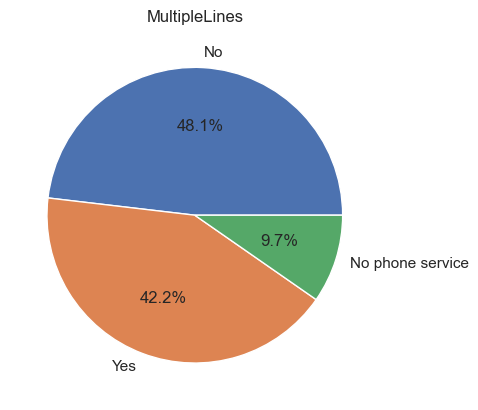

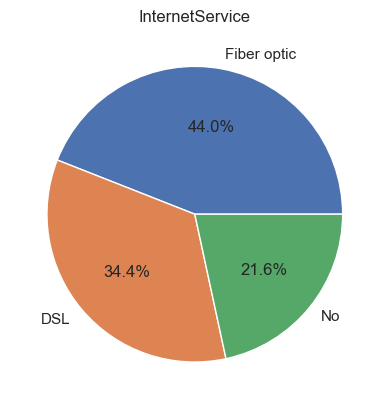

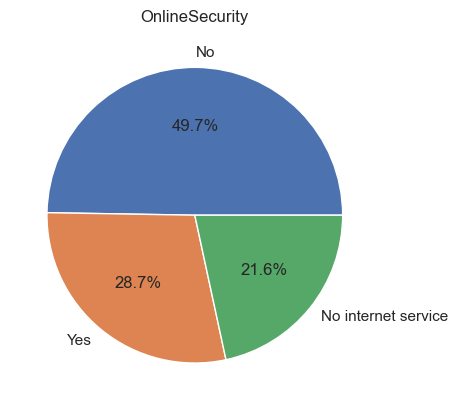

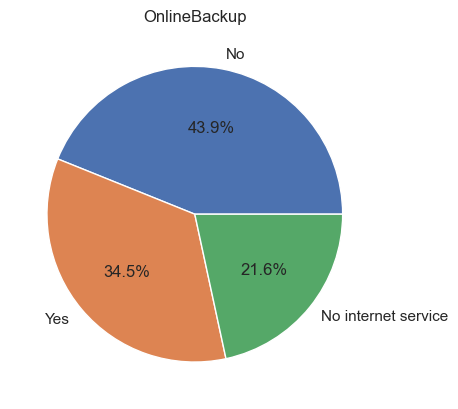

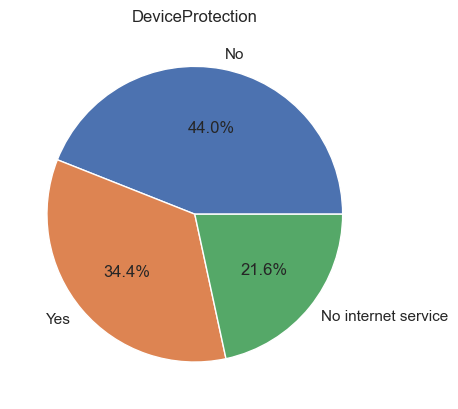

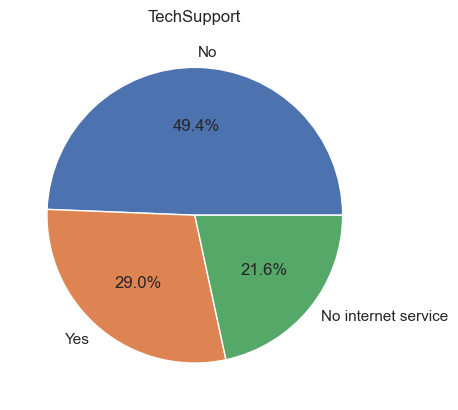

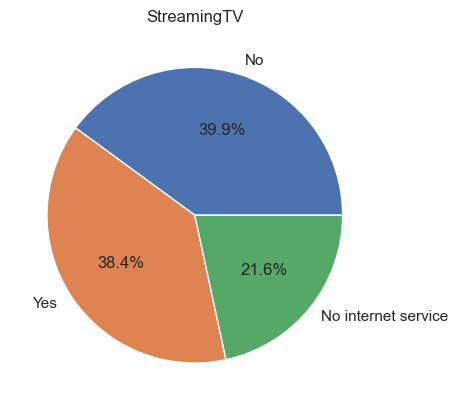

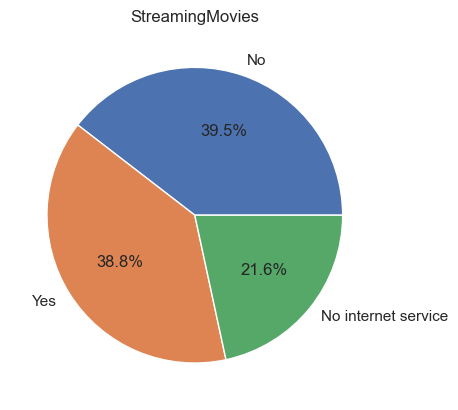

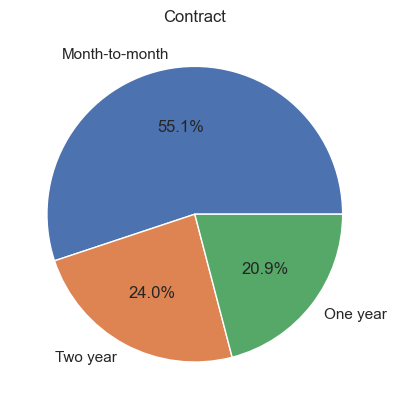

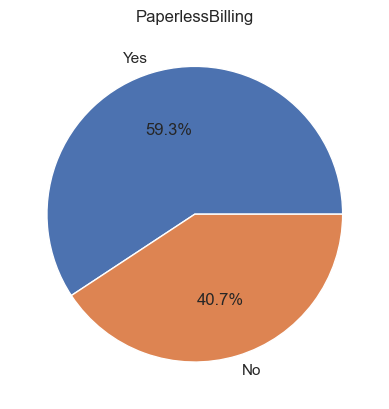

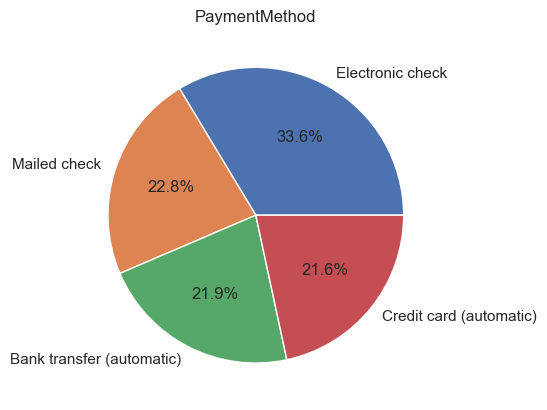

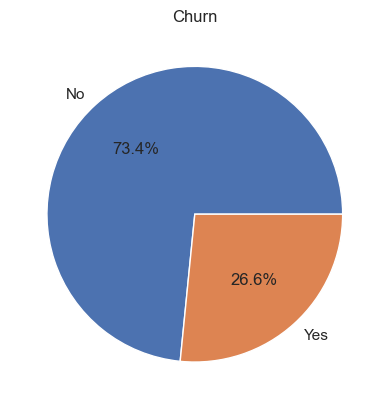

In [122]:
for col in df.select_dtypes('object').columns:
    plt.figure()
    plt.title('{}'.format(col))
    plt.pie(x = df[col].value_counts(), labels= df[col].value_counts().index, autopct='%1.1f%%')

<Axes: >

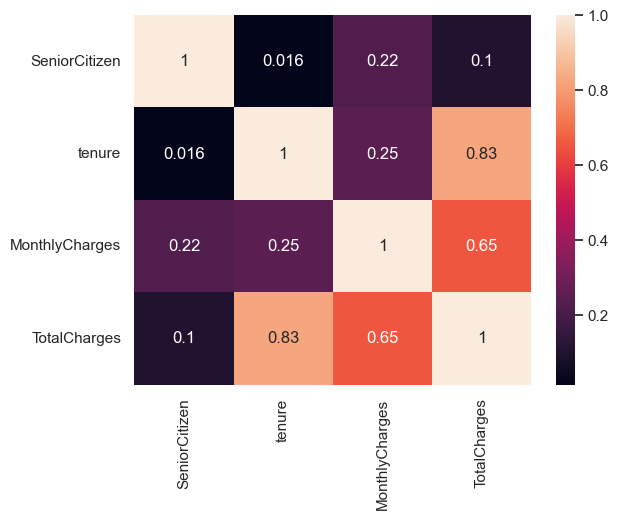

In [123]:
sns.heatmap(data = df.select_dtypes(['int','float']).corr(), annot = True)

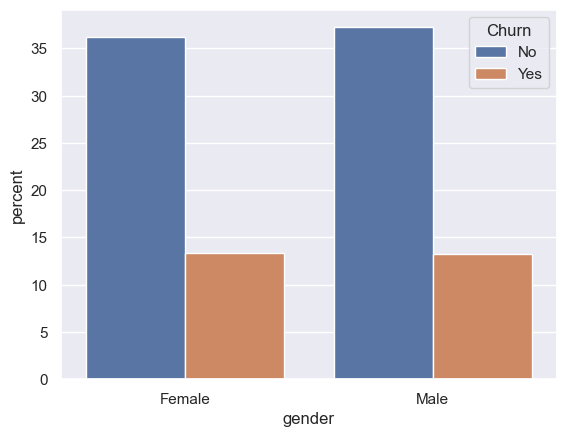

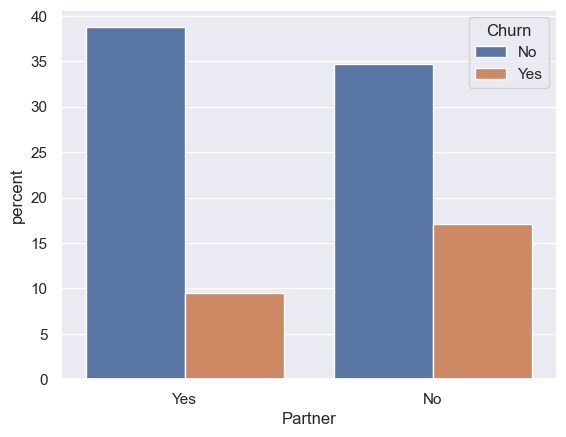

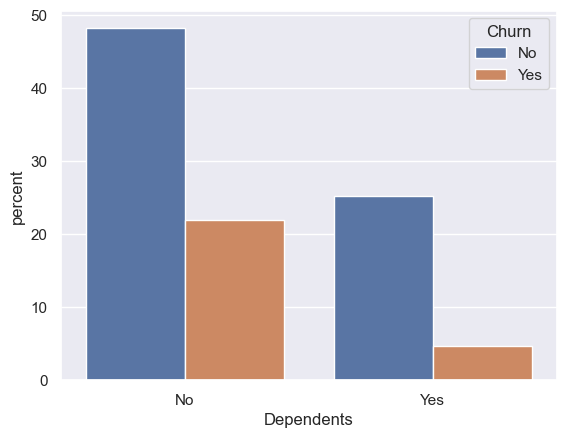

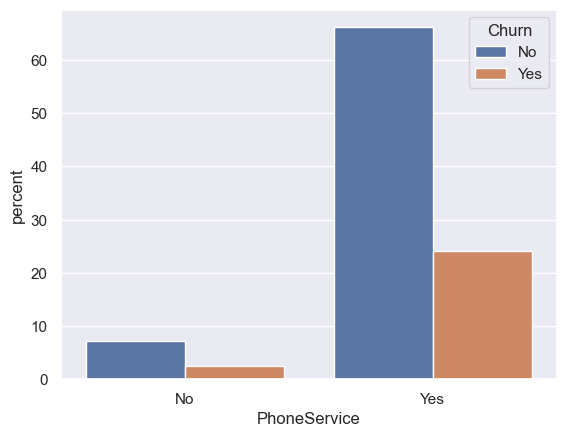

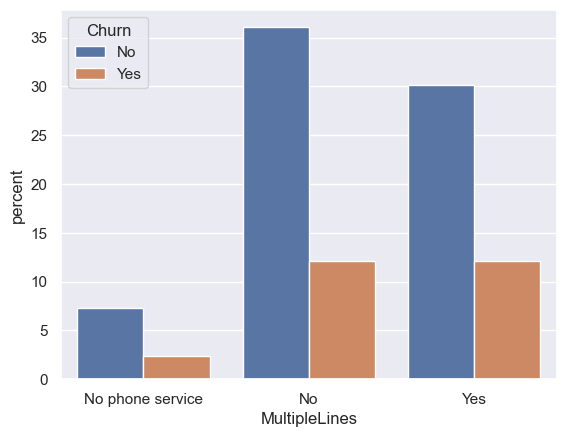

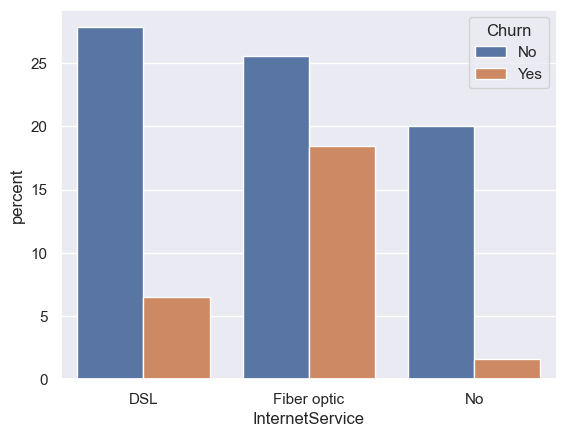

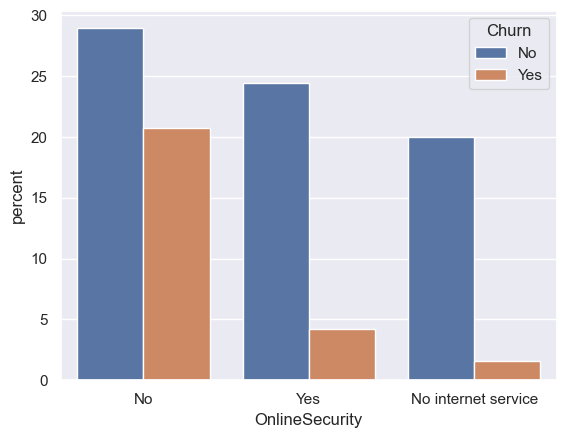

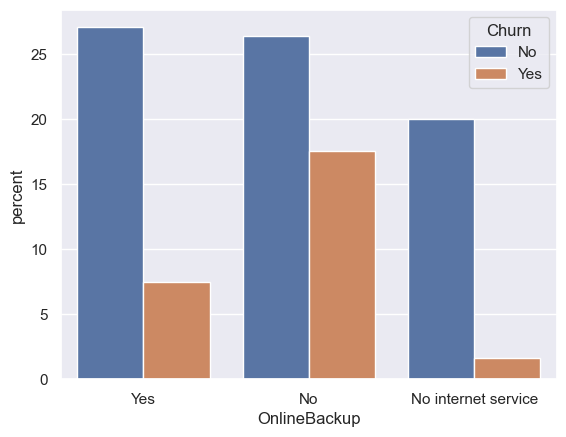

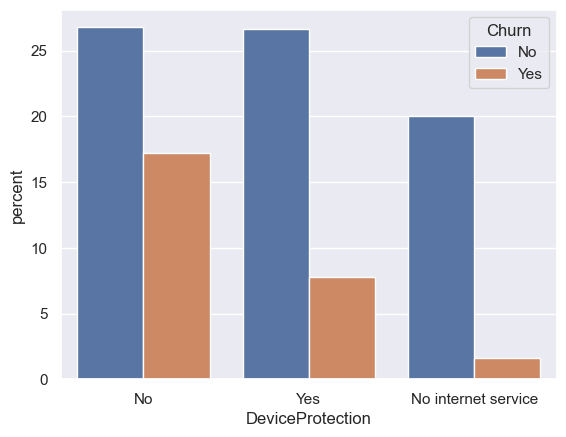

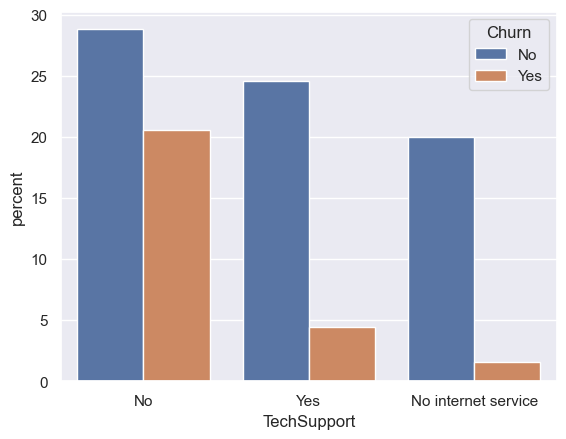

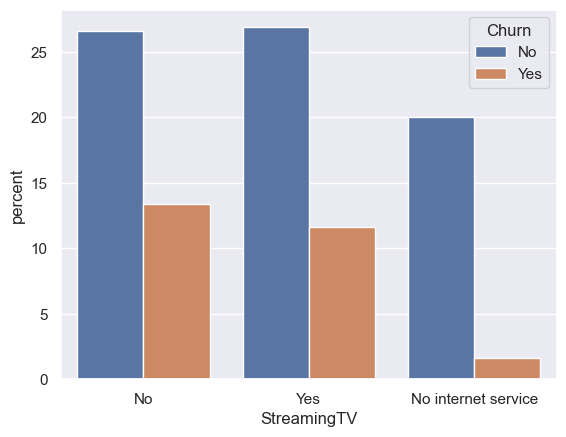

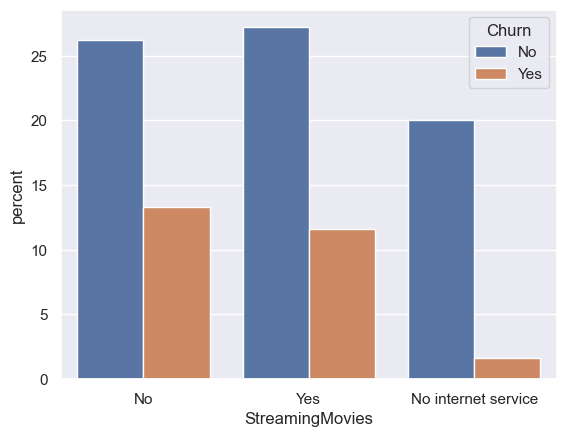

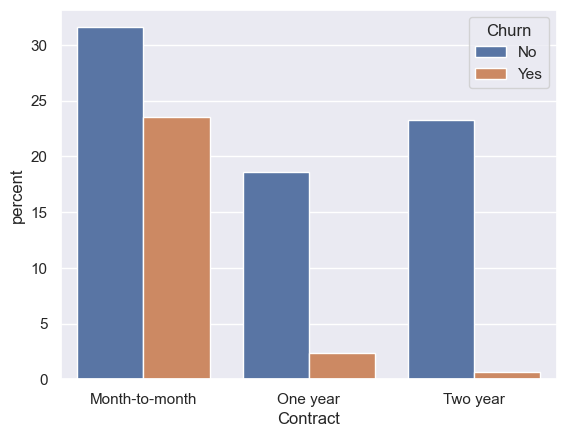

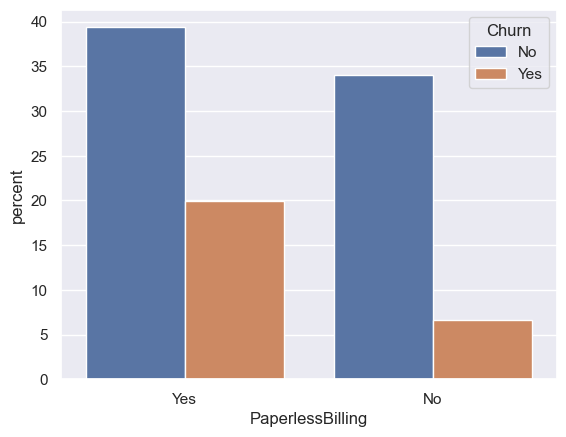

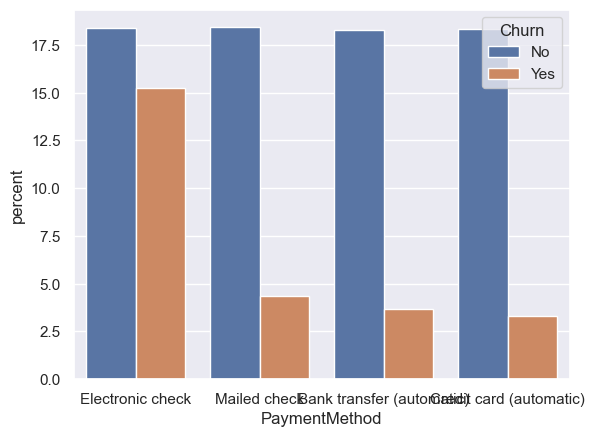

In [124]:
for col in df.select_dtypes('object').columns.drop(['Churn']):
    plt.figure()
    sns.countplot(data = df, x = col, hue = 'Churn', stat = 'percent');

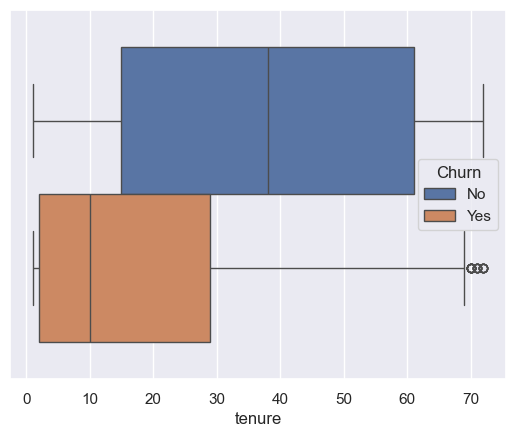

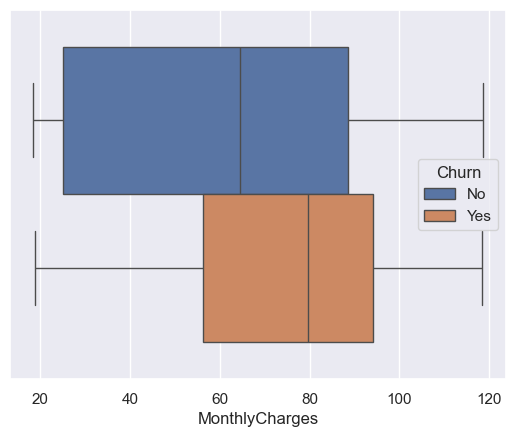

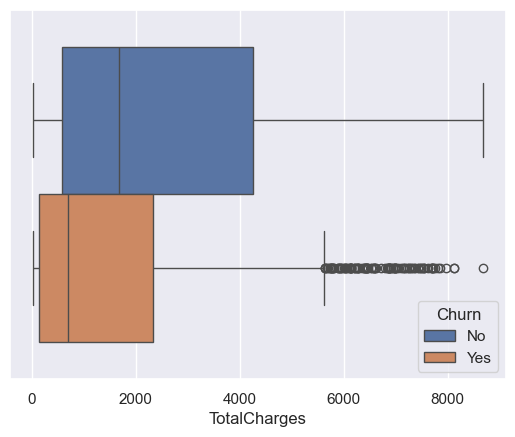

In [125]:
for col in df.select_dtypes(['int','float']).columns[1:]:
    plt.figure()
    sns.boxplot(data = df, x = col, hue = 'Churn')

### Préprocessing

In [126]:
# sélectionner les variables binaires Yes or No et les remplacer respectivement par 1 et 0
def selectionner_colonnes_binaires (df):
    colonnes_binaires = []
    for col in df.select_dtypes('object').columns:
        if set(df[col].unique()) == {"Yes","No"}:
            colonnes_binaires.append(col)
    return colonnes_binaires

df[selectionner_colonnes_binaires] = df[selectionner_colonnes_binaires(df)].replace({"Yes" : 1, "No" : 0})

In [127]:
# remplacer female par 0 et male par 1
df['gender'] = df['gender'].replace({"Female" : 0, "Male" : 1})

# one hot encoding
df = pd.get_dummies(data = df)

# supprimer toutes les colonnes contenant no internet service sauf une car toutes identiques
df = df.drop([col for col in df.columns if "No internet service" in col][1:], axis = 1)

#Supprimer la colonne no_phone_service de multiplelines car info déjà dans la variable PhoneService
df.drop('MultipleLines_No phone service', axis = 1, inplace=True)

# Renommer la colonne "No_internet_service"
df = df.rename(columns={"OnlineSecurity_No internet service" : "No_internet_service"})

In [128]:
df.shape

(7032, 35)

### Modélisation

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest

In [130]:
# séparations du jeu de données en target et data
target = df.Churn
data = df.drop('Churn', axis = 1)

In [ ]:
# jeu d'entraînement et jeu de test
x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.2,random_state=66)

In [142]:
scaler = StandardScaler()
selector = SelectKBest()
clf_lr = LogisticRegression()
clf_svm = SVC()
clf_rf = RandomForestClassifier()
clf_dt = DecisionTreeClassifier()

list_of_models = [('Logistic Regression', clf_lr),
                  ('Support Vector Machine', clf_svm),
                  ('Random Forest', clf_rf),
                  ('Decision Tree', clf_dt)]

results = {}

for name, model in list_of_models:
    print(f"Optimisation des hyperparamètres pour : {name}")
    model_pipeline = Pipeline(steps=[('normalisation', scaler),
                                     ('kbest', selector),
                                     ('model', model)])

    params = {}

    if name == 'Logistic Regression':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 35],
                  'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                  'model__C': [0.001, 0.01, 0.1, 1]}
    elif name == 'Support Vector Machine':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 35],
                  'model__C': [0.1, 1, 10],
                  'model__gamma': ['scale', 'auto', 0.001, 0.1],
                  'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
    elif name == 'Random Forest':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 35],
                  'model__n_estimators': [100, 200, 300],
                  'model__max_depth': [None, 5, 10],
                  'model__min_samples_split': [2, 5],
                  'model__min_samples_leaf': [1, 3]}
    elif name == 'Decision Tree':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 35],
                  'model__criterion': ['gini', 'entropy'],
                  'model__max_depth': [None, 5, 10],
                  'model__min_samples_split': [2, 5],
                  'model__min_samples_leaf': [1, 3]}

    grid = RandomizedSearchCV(model_pipeline, params, cv=5, scoring='accuracy', n_jobs=-1)  # Utilisation de model_pipeline et ajout du scoring
    grid.fit(x_train, y_train)

    print(f"Meilleurs hyperparamètres pour {name}: {grid.best_params_}")
    print(f"Meilleur score (validation croisée) pour {name}: {grid.best_score_}")
    results[name] = {'best_score': grid.best_score_, 'best_params': grid.best_params_, 'best_model': grid.best_estimator_}

print("\nRésultats comparatifs :")
for name, result in results.items():
    print(f"{name}: Meilleur score = {result['best_score']:.4f}, Meilleurs paramètres = {result['best_params']}")

Optimisation des hyperparamètres pour : Logistic Regression


c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antho\AppData\

Meilleurs hyperparamètres pour Logistic Regression: {'model__solver': 'saga', 'model__C': 1, 'kbest__k': 30}
Meilleur score (validation croisée) pour Logistic Regression: 0.7992888888888888
Optimisation des hyperparamètres pour : Support Vector Machine


c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antho\AppData\

Meilleurs hyperparamètres pour Support Vector Machine: {'model__kernel': 'sigmoid', 'model__gamma': 0.001, 'model__C': 10, 'kbest__k': 30}
Meilleur score (validation croisée) pour Support Vector Machine: 0.7955555555555556
Optimisation des hyperparamètres pour : Random Forest


c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antho\AppData\

Meilleurs hyperparamètres pour Random Forest: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 10, 'kbest__k': 20}
Meilleur score (validation croisée) pour Random Forest: 0.8033777777777777
Optimisation des hyperparamètres pour : Decision Tree
Meilleurs hyperparamètres pour Decision Tree: {'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 5, 'model__criterion': 'entropy', 'kbest__k': 10}
Meilleur score (validation croisée) pour Decision Tree: 0.7998222222222222

Résultats comparatifs :
Logistic Regression: Meilleur score = 0.7993, Meilleurs paramètres = {'model__solver': 'saga', 'model__C': 1, 'kbest__k': 30}
Support Vector Machine: Meilleur score = 0.7956, Meilleurs paramètres = {'model__kernel': 'sigmoid', 'model__gamma': 0.001, 'model__C': 10, 'kbest__k': 30}
Random Forest: Meilleur score = 0.8034, Meilleurs paramètres = {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_

c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antho\AppDat